In [1]:
from matplotlib.pylab import *
from jax import  numpy as jnp
from flax import linen as nn
import numpy as np
from typing import Any, Callable, Optional, Tuple, Type, List
from jax import lax, random, numpy as jnp
import einops
import torchio
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import jax
# import monai_swin_nD
import tensorflow as tf
# import monai_einops
import torch 
import einops
import torchio as tio
import optax
from flax.training import train_state  # Useful dataclass to keep train state
from torch.utils.data import DataLoader
import h5py
import jax
from testUtils.spleenTest import get_spleen_data
from testUtils.tensorboard_utils import *
from ml_collections import config_dict
from swinTransformer.optimasation import get_optimiser
import swinTransformer.swin_transformer as swin_transformer
from swinTransformer.swin_transformer import SwinTransformer
from swinTransformer.losses import focal_loss
from swinTransformer.metrics import dice_metr
from swinTransformer.optimasation import get_optimiser
# import augmentations.simpleTransforms
# from augmentations.simpleTransforms import main_augment
from testUtils.spleenTest import get_spleen_data
from jax.config import config
from skimage.segmentation import mark_boundaries
import cv2
import functools
# from torch.utils.tensorboard import SummaryWriter
# import torchvision.transforms.functional as F
# import torchvision
import flax.jax_utils as jax_utils
import tensorflow as tf
from jax_smi import initialise_tracking
import ml_collections
import time
import more_itertools
import toolz
from subprocess import Popen
from flax.training import checkpoints, train_state
from flax import struct, serialization
import orbax.checkpoint
from datetime import datetime
from flax.training import orbax_utils
from flax.core.frozen_dict import freeze

from super_voxels.SIN.SIN_jax_2D_simpler.model_sin_jax_2D import SpixelNet
from super_voxels.SIN.SIN_jax_2D_simpler.model_sin_jax_utils_2D import *
from super_voxels.SIN.SIN_jax_2D_simpler.shape_reshape_functions import *

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
jax.numpy.set_printoptions(linewidth=400)

# config.update("jax_debug_nans", True)
# config.update("jax_disable_jit", True)
# config.update('jax_platform_name', 'cpu')
cfg = config_dict.ConfigDict()
cfg.total_steps=7000
# cfg.learning_rate=0.00002 #used for warmup with average coverage loss
# cfg.learning_rate=0.0000001
cfg.learning_rate=0.00000002

cfg.num_dim=4
cfg.batch_size=50

cfg.batch_size_pmapped=np.max([cfg.batch_size//jax.local_device_count(),1])
cfg.img_size = (cfg.batch_size,1,256,256)
cfg.label_size = (cfg.batch_size,256,256)
cfg.r_x_total= 3
cfg.r_y_total= 3
cfg.orig_grid_shape= (cfg.img_size[2]//2**cfg.r_x_total,cfg.img_size[3]//2**cfg.r_y_total,cfg.num_dim)
cfg.masks_num= 4# number of mask (4 in 2D and 8 in 3D)
cfg.volume_corr= 10000# for standardizing the volume - we want to penalize the very big and very small supervoxels 
                    # the bigger the number here the smaller the penalty

##getting the importance of the losses associated with deconvolutions
## generally last one is most similar to the actual image - hence should be most important
cfg.deconves_importances=(0.1,0.5,1.0)
#some constant multipliers related to the fact that those losses are disproportionally smaller than the other ones
cfg.edge_loss_multiplier=10.0
cfg.feature_loss_multiplier=10.0
cfg.percent_weak_edges=0.45
#just for numerical stability
cfg.epsilon=0.0000000000001
cfg = ml_collections.FrozenConfigDict(cfg)

In [7]:
f = h5py.File('/workspaces/Jax_cuda_med/data/hdf5_loc/example_mask.hdf5', 'r+')
masks=f['masks'][:,:,:]    
curr_image=f['image'][:,:]    


mm (16, 16)


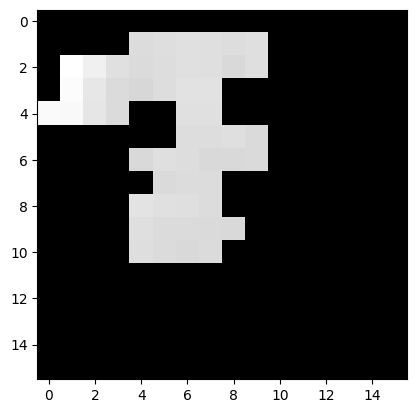

mm (16, 16)


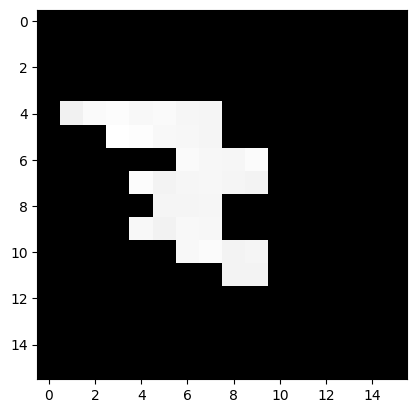

mm (16, 16)


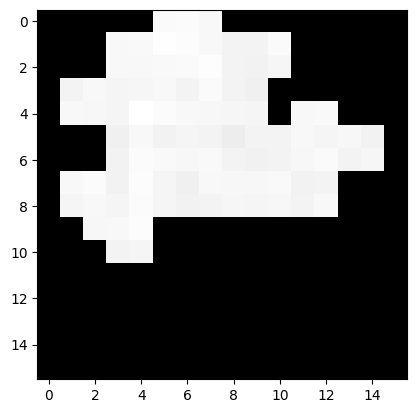

mm (16, 16)


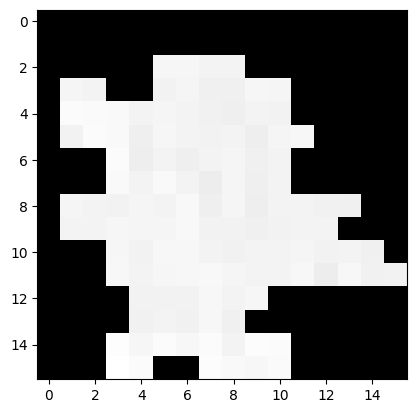

In [20]:
initial_masks= jnp.stack([
    get_initial_supervoxel_masks(cfg.orig_grid_shape,0,0),
    get_initial_supervoxel_masks(cfg.orig_grid_shape,1,0),
    get_initial_supervoxel_masks(cfg.orig_grid_shape,0,1),
    get_initial_supervoxel_masks(cfg.orig_grid_shape,1,1)
        ],axis=0)
initial_masks=jnp.sum(initial_masks,axis=0)

def work_on_single_area(curr_id,mask_curr,image):
    filtered_mask=filter_mask_of_intrest(mask_curr,curr_id)
    filtered_mask=einops.rearrange(filtered_mask,'w h-> w h 1')
    masked_image= jnp.multiply(image,filtered_mask)
    return masked_image

v_work_on_single_area=jax.vmap(work_on_single_area)
v_v_work_on_single_area=jax.vmap(v_work_on_single_area)
# masks=einops.rearrange(masks,'x y p ->1 x y p')
initial_masks=einops.rearrange(initial_masks,'x y p ->1 x y p')

shape_reshape_cfgs=get_all_shape_reshape_constants(cfg,r_x=3,r_y=3)
shape_reshape_cfgs_old=get_all_shape_reshape_constants(cfg,r_x=3,r_y=2)


def iter_over_masks(shape_reshape_cfgs,i,masks,curr_image):
    shape_reshape_cfg=shape_reshape_cfgs[i]
    shape_reshape_cfg_old=shape_reshape_cfgs_old[i]
    curr_ids=initial_masks[:,shape_reshape_cfg.shift_x: shape_reshape_cfg.orig_grid_shape[0]:2,shape_reshape_cfg.shift_y: shape_reshape_cfg.orig_grid_shape[1]:2,: ]
    curr_ids=einops.rearrange(curr_ids,'b x y p ->b (x y) p')
    mask_curr=divide_sv_grid(masks,shape_reshape_cfg)
    curr_image=einops.rearrange(curr_image,'x y ->1 x y 1')

    curr_image_in=divide_sv_grid(curr_image,shape_reshape_cfg)

    to_reshape_back_x=np.floor_divide(shape_reshape_cfg.axis_len_x,shape_reshape_cfg.diameter_x)
    to_reshape_back_y=np.floor_divide(shape_reshape_cfg.axis_len_y,shape_reshape_cfg.diameter_y) 

    to_reshape_back_x_old=np.floor_divide(shape_reshape_cfg_old.axis_len_x,shape_reshape_cfg_old.diameter_x)
    to_reshape_back_y_old=np.floor_divide(shape_reshape_cfg_old.axis_len_y,shape_reshape_cfg_old.diameter_y) 

    masked_image = v_v_work_on_single_area(curr_ids,mask_curr,curr_image_in)
        
    # masked_image=recreate_orig_shape(masked_image,shape_reshape_cfg,to_reshape_back_x,to_reshape_back_y )

    return masked_image

for i in range(4):        
    masked_image= iter_over_masks(shape_reshape_cfgs,i,masks,curr_image)
    mm=masked_image[0,50,:,:,0]
    print(f"mm {mm.shape}")
    plt.imshow(mm)
    plt.gray()
    plt.show()

